In [1]:
import collections
import typing
import numpy as np
import tqdm
import re
import nltk

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
NUMBER_TOKEN = 'NUMBER'
NGRAM_SEP = '_'
TILDA_SEP = '~'
UNK_TOKEN = 'UNK'

In [3]:
en_stopwords = nltk.corpus.stopwords.words('english')

In [8]:
# 1. Read text

with open('data/text_small.txt', 'r') as f:
    raw_data = f.read()
    # Get rid of underscores and tildas
    raw_data = raw_data.replace('_', ' ')
    raw_data = raw_data.replace('~', ' ')

len(raw_data)

2940422

In [10]:
# tmp = raw_data[:2000]
tmp = raw_data
tmp_sent = nltk.tokenize.sent_tokenize(tmp)
tmp_sent[:2]

['BACKGROUND: Rivaroxaban is currently used to prevent stroke in patients with atrial fibrillation.',
 'Measuring coagulation function may help clinicians to understand the effects of this drug and the associated risk of bleeding.']

In [36]:
'kek'.replace('e', ' ').replace('k', 'a')

'a a'

In [39]:
def regexp_word_tokenize(string: str) -> list:
    # FIX: it doesn't split by underscore!!
    rgx = re.compile("([\w]*\w)")
    return rgx.findall(string)


def merge_numbers(words: list) -> list:
    def startswith_digit(string: str) -> bool:
        return string[0].isdigit()
 
    ans = []
    i = 0
    while i < len(words):
        j = 0
        while i + j < len(words) and startswith_digit(words[i + j]):
            j += 1
        if i + j > 1 and startswith_digit(words[i + j - 1]):
            ans.append(NUMBER_TOKEN)
        if i + j < len(words):
            ans.append(words[i + j])
        i += j + 1
    return ans


def cool_tokenize(string: str) -> list:
    """
    Tokenize and replace numbers with `NUMBER_TOKEN`.
    """
    string = string.lower()
    tkzd = regexp_word_tokenize(string)
    return merge_numbers(tkzd)

In [40]:
# 2. Tokenize each of sentences

tmp_sent_tkzd = list(map(lambda x: cool_tokenize(x), tmp_sent))
tmp_sent_tkzd = list(filter(lambda x: len(x), tmp_sent_tkzd))
tmp_sent_tkzd[:2]

[['background',
  'rivaroxaban',
  'is',
  'currently',
  'used',
  'to',
  'prevent',
  'stroke',
  'in',
  'patients',
  'with',
  'atrial',
  'fibrillation'],
 ['measuring',
  'coagulation',
  'function',
  'may',
  'help',
  'clinicians',
  'to',
  'understand',
  'the',
  'effects',
  'of',
  'this',
  'drug',
  'and',
  'the',
  'associated',
  'risk',
  'of',
  'bleeding']]

In [63]:
def make_ngrams(words: list, upto=2) -> list:
    if len(words) > 1:
        res = []
        for i in range(1, upto + 1):
            res.extend(nltk.ngrams(words, i))
        return res
    else:
        return [tuple(words)]

In [64]:
# 3. Get ngrams for each of sentences

tmp_ngrams = list(map(lambda x: make_ngrams(x, 3), tmp_sent_tkzd))
tmp_ngrams[:1]

[[('background',),
  ('rivaroxaban',),
  ('is',),
  ('currently',),
  ('used',),
  ('to',),
  ('prevent',),
  ('stroke',),
  ('in',),
  ('patients',),
  ('with',),
  ('atrial',),
  ('fibrillation',),
  ('background', 'rivaroxaban'),
  ('rivaroxaban', 'is'),
  ('is', 'currently'),
  ('currently', 'used'),
  ('used', 'to'),
  ('to', 'prevent'),
  ('prevent', 'stroke'),
  ('stroke', 'in'),
  ('in', 'patients'),
  ('patients', 'with'),
  ('with', 'atrial'),
  ('atrial', 'fibrillation'),
  ('background', 'rivaroxaban', 'is'),
  ('rivaroxaban', 'is', 'currently'),
  ('is', 'currently', 'used'),
  ('currently', 'used', 'to'),
  ('used', 'to', 'prevent'),
  ('to', 'prevent', 'stroke'),
  ('prevent', 'stroke', 'in'),
  ('stroke', 'in', 'patients'),
  ('in', 'patients', 'with'),
  ('patients', 'with', 'atrial'),
  ('with', 'atrial', 'fibrillation')]]

In [65]:
def contains_stopword(ngram: tuple, stopwords=en_stopwords) -> bool:
    list_of_bool = list(map(lambda x: x in stopwords, ngram))
    return any(list_of_bool)

def remove_bad_ngrams(ngrams: list) -> list:
    return list(filter(lambda x: contains_stopword(x) == False, ngrams))

In [71]:
# 4. Remove ngrams containing stopwords

tmp_ngrams_clean = list(map(lambda x: remove_bad_ngrams(x), tmp_ngrams))

In [12]:
def get_unigrams(ngrams: list) -> list:
    unigram_tuples = list(filter(lambda x: len(x) == 1, ngrams))
    unigrams = list(map(lambda x: x[0], unigram_tuples))
    return unigrams

def make_sentence(ngrams: list):
    unigrams = get_unigrams(ngrams)
    return ' '.join(unigrams)

In [13]:
# 5. Make sentences

tmp_sent_clean = list(map(lambda x: make_sentence(x), tmp_ngrams_clean))
tmp_sent_clean[:2]

['background rivaroxaban currently used prevent stroke patients atrial fibrillation',
 'measuring coagulation function may help clinicians understand effects drug associated risk bleeding']

In [14]:
from collections import Counter

In [15]:
def process_ngrams(ngrams: list) -> list:
    return list(map(lambda x: NGRAM_SEP.join(x), ngrams))

import itertools

merged_ngrams = list(itertools.chain.from_iterable(tmp_ngrams_clean))

In [16]:
cntr = Counter(process_ngrams(merged_ngrams))
cntr['age']

269

In [17]:
THRESHOLD = 3
cntr_thr = list(filter(lambda x: x[1] > THRESHOLD, cntr.items()))

In [18]:
# 6. Building dictionary

dictionary = {UNK_TOKEN: 0}
for item, _ in cntr_thr:
    dictionary[item] = len(dictionary)

In [19]:
reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
# dictionary, reversed_dictionary

In [20]:
def get_ngrams_from_dict(dictionary: dict) -> list:
    return list(filter(lambda x: NGRAM_SEP in x, dictionary.keys()))

def get_tildas_from_dict(dictionary: dict) -> list:
    return list(filter(lambda x: TILDA_SEP in x, dictionary.keys()))

def split_ngrams(ngrams: list) -> list:
    return list(map(lambda x: x.split(NGRAM_SEP), ngrams))

def sort_ngrams(ngrams: list) -> list:
    return list(map(lambda x: sorted(x), ngrams))

def make_tilda_tokens(ngrams: list) -> list:
    return list(map(lambda x: TILDA_SEP.join(x), ngrams))

def unique_tilda_tokens(dictionary: dict) -> list:
    return list(set(make_tilda_tokens(sort_ngrams(split_ngrams(get_ngrams_from_dict(dictionary))))))

In [21]:
uniqs = unique_tilda_tokens(dictionary)

In [22]:
# 7. Extend dictionary with tilda tokens

for item in uniqs:
    dictionary[item] = len(dictionary)

In [23]:
reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
len(dictionary)

22055

In [24]:
def replace_unk(string: str, dictionary=dictionary) -> str:
    list_unk = list(map(lambda x: x if x in dictionary else UNK_TOKEN, string.split()))
    return ' '.join(list_unk)

def tokenize_ids(string: str, dictionary=dictionary) -> list:
    return list(map(lambda x: dictionary[x] if x in dictionary else dictionary[UNK_TOKEN], string.split()))

In [25]:
# 8. Replace out-of-vocabulary words with `UNK_TOKEN`

tmp_sent_unk = list(map(lambda x: replace_unk(x), tmp_sent_clean))
tmp_sent_unk = list(filter(lambda x: len(x) > 0, tmp_sent_unk))

In [26]:
def sent_contains(sentence, pattern):
    return all(list(map(lambda x: x in sentence, pattern)))

def indices_for_ngram(ngram: str) -> tuple:
#     indices = tuple(list(map(lambda x: dictionary[x], ngram.split(NGRAM_SEP))))
    indices = []
    for i in ngram.split(NGRAM_SEP):
        if i not in dictionary:
            return None
        indices.append(dictionary[i])
    return tuple([tuple(indices), dictionary[ngram]])

def indices_for_tilda(ngram: str) -> tuple:
#     indices = sorted(list(map(lambda x: dictionary[x], ngram.split(TILDA_SEP))))
#     indices = tuple(indices)
    indices = []
    for i in ngram.split(TILDA_SEP):
        if i not in dictionary:
            return None
        indices.append(dictionary[i])
    return tuple([tuple(sorted(indices)), dictionary[ngram]])

In [27]:
ngrams_from_dict = get_ngrams_from_dict(dictionary)
tildas_from_dict = get_tildas_from_dict(dictionary)

In [28]:
dict_ngram_id_by_tuple = {}
dict_tilda_id_by_tuple = {}

# ngrams
for ngram in ngrams_from_dict:
    tmp = indices_for_ngram(ngram)
    if tmp is not None:
        words_tup, ngram_id = tmp
        dict_ngram_id_by_tuple[words_tup] = ngram_id
    
# tildas
for tilda in tildas_from_dict:
    tmp = indices_for_tilda(tilda)
    if tmp is not None:
        words_tup, tilda_id = tmp
        dict_tilda_id_by_tuple[words_tup] = tilda_id
    
def ngram_id(ngram_tuple: tuple) -> int:
    if ngram_tuple in dict_ngram_id_by_tuple:
        return dict_ngram_id_by_tuple[ngram_tuple]
    else:
        return 0
    
def tilda_id(tilda_tuple: tuple) -> int:
    tilda_tuple = tuple(sorted(tilda_tuple))
    if tilda_tuple in dict_tilda_id_by_tuple:
        return dict_tilda_id_by_tuple[tilda_tuple]
    else:
        return 0

In [29]:
indices_for_ngram(ngrams_from_dict[0])

((3, 4), 10)

In [30]:
reversed_dictionary[3], reversed_dictionary[4], reversed_dictionary[10]

('currently', 'used', 'currently_used')

In [31]:
indices_for_tilda('currently~used'), indices_for_ngram('currently_used')

(((3, 4), 19331), ((3, 4), 10))

In [32]:
reversed_dictionary[1506], reversed_dictionary[1383], reversed_dictionary[6770]

('NUMBER_mmhg', 'repressor', 'apolipoprotein')

In [33]:
reversed_dictionary[436], reversed_dictionary[437], reversed_dictionary[447]

('staphylococcus', 'aureus', 'staphylococcus_aureus')

In [60]:
# Try to train word2gauss.

from word2gauss import GaussianEmbedding, iter_pairs
from word2gauss.words import Vocabulary

vocab_gauss = Vocabulary(dictionary)
embed = GaussianEmbedding(len(dictionary), 100,
                          covariance_type='diagonal',
                          energy_type='KL')

In [61]:
len(tmp_sent_unk)

18572

In [50]:
# tmp_sent_unk = sorted()
tmp_sent_unk = sorted(tmp_sent_unk, key=lambda x: len(x.split()))

In [64]:
%%time
embed.train(
    iter_pairs(tmp_sent_unk[10:], vocab_gauss, ngram_id,
               tilda_id, batch_size=10, nsamples=2,
               window=5, n=3),
    n_workers=8)

CPU times: user 2min 10s, sys: 7.15 s, total: 2min 17s
Wall time: 1min 48s


In [91]:
# list(filter(lambda x: x.count(NGRAM_SEP) == 2, get_ngrams_from_dict(dictionary)))

In [78]:
def nearest(token, num=10):
    return [x["word"] for x in embed.nearest_neighbors([(token,)], vocab=vocab_gauss, num=num)]

In [79]:
nearest('normal_breast_tissue')

['normal_breast_tissue',
 'including~outcomes',
 'mcrc',
 'NUMBER_effect',
 'age_groups',
 'wt1',
 'insertion',
 'udder_cream_r',
 'randomly_assigned',
 'nd']

In [80]:
nearest('radix_paeoniae_rubra')

['radix_paeoniae_rubra',
 'suspensions',
 'endocycling',
 'binuclear_complex',
 'dcr',
 'powered',
 'cf3_NUMBER',
 'gene~mthfr',
 'co2',
 'causative']

In [81]:
nearest('amino_acid')

['amino_acid',
 'rpe',
 'liver_cancer',
 'high~prevalence',
 'vulnerability',
 'w~w',
 'associated~gelatinase',
 'breeds',
 'preclinical~studies',
 'hundred~one']

In [89]:
nearest('wistar')

['wistar', 'campylobacter', 'groups', 'week', 'hsl', 'rats', 'studied', 'morning', 'neovascularization', 'calcitriol', 'group~p', 'old', 'female', 'count', 'ethanol', 'consist', 'centres', 'findings_suggest', 'aged', 'cx26']


In [82]:
print([x["word"] for x in embed.nearest_neighbors([('male',)], vocab=vocab_gauss, num=20)])

['male', 'homozygous', 'iqr', 'NUMBER~age', 'NUMBER~cohort', 'experienced', 'female', 'odds', 'acute', 'underwent', 'abmd', 'bcva', 'infarction', 'mean', 'NUMBER~risk', 'boys', 'summary', 'surgery', 'NUMBER~confidence', 'npdr']


In [93]:
print([x["word"] for x in embed.nearest_neighbors([('crf01',)], vocab=vocab_gauss, num=20)])

['crf01', 'translocated', 'findings_suggest', 'mediators', 'choroid', 'data_reveal', 'hematologic', 'oocytes', 'wky', 'results_suggest', 'retrieved', 'outcomes_including', 'theoretical', 'caudate', 'extreme', 'elevated~serum', 'cyclobutane', 'lung_disease', 'dfs', 'mediated_induction']


In [97]:
print([x["word"] for x in embed.nearest_neighbors([('ae',)], vocab=vocab_gauss, num=20)])

['ae', 'crystal~structures', 'accompanied', 'serotonin_NUMBER', 'cu_ii', 'nmr', 'bioassays', 'phox', 'c_elegans', 'neurotrophic_factor', 'pg_NUMBER', 'mm_hg', 'formers~stone', 'mt', 'vs_placebo', 'rna', 'significantly_enhanced', 'monophosphate', 'NUMBER~gene', 'NUMBER_samples']


In [83]:
def calc_kl(bigram):
    """
    Calculate KL-divergence.
    
    Parameters
    ----------
    bigram : string
    
    Returns
    -------
    Calculated KL-divergence.
    
    """
    def gaus_repr(token):
        """
        Returns
        -------
        list of mus, list of sigmas
        
        """
        if TILDA_SEP in token:
            token = token.split(TILDA_SEP)
            token = sorted(token)
            token = TILDA_SEP.join(token)
        mu = embed.mu[vocab_gauss.word2id(token)]
        sigma = np.diag(embed.sigma[vocab_gauss.word2id(token)]) # Diagonal matrix.
        return mu, sigma

    # Gaussian representation of `bigram`.
    mu_bigram, sigma_bigram = gaus_repr(bigram)
    
    # Gaussian representation of tilda-token.
    tilda = bigram.replace('_', '~')
    mu_tilda, sigma_tilda = gaus_repr(tilda)
    
    def gaussian_kl(gaus1, gaus2):
        ans = (1. / 2.) * \
              (np.trace(np.dot(np.linalg.inv(gaus2['sigma']), gaus1['sigma'])) + 
               np.dot(gaus2['mu'] - gaus1['mu'], np.dot(np.linalg.inv(gaus2['sigma']), gaus2['mu'] - gaus1['mu'])) - 
               len(gaus1['mu']) + np.log(np.linalg.det(gaus2['sigma']) / np.linalg.det(gaus1['sigma'])))
        return ans
    
    gaus_tilda =  {'mu' : mu_tilda,  'sigma' : sigma_tilda}
    gaus_bigram = {'mu' : mu_bigram, 'sigma' : sigma_bigram}
    
    return gaussian_kl(gaus_bigram, gaus_tilda)

In [85]:
calc_kl('important_role')

5.7544670104980469

In [86]:
calc_kl('amino_acid')

5.246495246887207

In [87]:
calc_kl('breast_cancer')

4.7753140926361084

In [88]:
calc_kl('crf01_ae')

5.404483437538147

In [89]:
calc_kl('radix_paeoniae_rubra')

5.3233507573604584

In [90]:
calc_kl('approximately_NUMBER_million')

4.8883925266563892

In [112]:
embed.mu.shape

(40270, 100)

In [113]:
len(dictionary)

20135

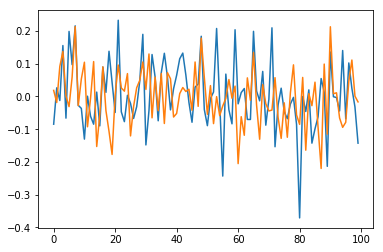

In [126]:
tmpid = 101
plt.plot(embed.mu[tmpid])
plt.plot(embed.mu[len(dictionary) + tmpid])

In [46]:
all_combinations = []
for i in range(2, 2 + 1):
    all_combinations.extend(itertools.combinations([1,], i))
all_combinations

[]

In [ ]:
def gaus_repr(token):
    """
    Gaussian representation of token.
    :return: mu and sigma
    """
    if TILDA_SEP in token:
        token = token.split(TILDA_SEP)
        token = sorted(token)
        token = TILDA_SEP.join(token)

    return (embed.mu[vocab_gauss.word2id(token)],
            np.diag(embed.sigma[vocab_gauss.word2id(token)]))  # Diagonal matrix.

    def calc_variational_kl(bigram, order=0):
        """
        Calculate KL-divergence of bigram and corresponding mixture.
        :param bigram: string
        :param order: int
            If order is 0, then KL(bigram, mixture) is calculated;
            if order is 1, then KL(mixture, bigram) is calculated.
        """
        word1 = bigram.split('_')[0]
        word2 = bigram.split('_')[1]

        # Gaussian representation of first word in `bigram`.
        mu1, sigma1 = self.gaus_repr(word1)

        # Gaussian representation of second word in `bigram`.
        mu2, sigma2 = self.gaus_repr(word2)

        mu_words = np.array([mu1, mu2])
        sigma_words = np.array([np.diag(sigma1), np.diag(sigma2)])

        # Gaussian representation of `bigram`.
        mu_bigram, sigma_bigram = self.gaus_repr(bigram)

        weights_words = [1./2., 1./2.]
        weights_bigram = [1.]

        def complex_kl(f, g):
            ans = 0
            for a, pi in enumerate(f['weights']):
                sum1 = 0
                sum2 = 0

                for b, ksi in enumerate(f['weights']):
                    params_a = {'mu': f['mus'][a], 'sigma': f['sigmas'][a]}
                    params_b = {'mu': f['mus'][b], 'sigma': f['sigmas'][b]}
                    sum1 += ksi * np.exp((-1.) * gaussian_kl(params_a, params_b))

                for c, omega in enumerate(g['weights']):
                    params_a = {'mu': f['mus'][a], 'sigma': f['sigmas'][a]}
                    params_c = {'mu': g['mus'][c], 'sigma': g['sigmas'][c]}
                    sum2 += omega * np.exp((-1) * gaussian_kl(params_a, params_c))

                ans += pi * np.log(sum1 / sum2)

            return ans

        if order == 0:
            g = {'mus': mu_bigram, 'sigmas': sigma_bigram, 'weights': weights_bigram}
            f = {'mus': mu_words, 'sigmas': sigma_words, 'weights': weights_words}
        elif order == 1:
            g = {'mus': mu_words, 'sigmas': sigma_words, 'weights': weights_words}
            f = {'mus': mu_bigram, 'sigmas': sigma_bigram, 'weights': weights_bigram}
        else:
            raise

        # KL(g, f)
        return complex_kl(g, f)

    def kl(self, bigram, order=0):
        '''
        Calculates kl-score of bigram and corresponding tilda-token.
        :param bigram: string
        :param order: int
            If order is 0, then KL(bigram, tilda-token) is calculated;
            if order is 1, then KL(tilda-token, bigram) is calculated.
        '''
        # Gaussian representation of `bigram`.
        mu_bigram, sigma_bigram = self.gaus_repr(bigram)

        # Gaussian representation of tilda-token.
        tilda = bigram.replace('_', '~')
        mu_tilda, sigma_tilda = self.gaus_repr(tilda)

        if order == 0:
            gaus1 = {'mu': mu_bigram, 'sigma': sigma_bigram}
            gaus2 = {'mu': mu_tilda,  'sigma': sigma_tilda}
        elif order == 1:
            gaus1 = {'mu': mu_tilda,  'sigma': sigma_tilda}
            gaus2 = {'mu': mu_bigram, 'sigma': sigma_bigram}
        else:
            raise

        return gaussian_kl(gaus1, gaus2)

def score_ngrams(self, func_type=0, order=0):
    """
    :param func_type: int
        Which function to use to calculate KL-divergence.
        If type is 0, then the gaussian KL is used;
        if type is 1, then the variational KL is used.
    :param order: int
        If order is 0, then KL(bigram, token) is calculated;
        if order is 1, then KL(token, bigram) is calculated.
    :return: List of scored ngrams
    """
    res = {}

    func = None

    if func_type == 0:
        func = self.kl
    elif func_type == 1:
        func = self.calc_variational_kl
    else:
        raise

    for bigram in tqdm.tqdm(self.get_bigrams()):
        res[bigram] = func(bigram, order)

    return sorted(res.items(), key=lambda x: x[1], reverse=True)

In [146]:
for i in range(2, 3 + 1):
    print(i)

2
3


In [148]:
len(itertools.combinations([1,2,3], 2))

TypeError: object of type 'itertools.combinations' has no len()

#__processor___

In [378]:
from processor import Processor

In [379]:
proc = Processor(raw_data)

> Done with ._get_sentences()
> Done with ._get_dictionaries()
> Done with ._build_ids_tuples()


In [90]:
# proc.sentences

In [386]:
from word2gauss.words import Vocabulary
vocab_gauss = Vocabulary(dictionary)

In [91]:
vocab_gauss.tokenize_ids('this paper demonstrates that sulfide toxicity can be modified and dehydroascorbic acid functions as an effector in this process', remove_oov=False)

array([   0,  264, 1040,    0, 1022, 1041,    0,    0, 1042,    0, 1043,
       1044, 1025,    0,    0, 1045,    0,    0,  790], dtype=uint32)

In [4]:
proc.train_embeddings()